In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import numpy as np
import pickle
import random
import warnings

from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
from PIL import Image
from pathlib import Path
from __future__ import print_function, division

from torchvision import transforms, utils, models
from skimage import io, transform
from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")

np.set_printoptions(precision=2)
torch.set_printoptions(precision=4)
plt.ion()   # interactive mode
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

!nvidia-smi


SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

CUDA is available!  Training on GPU ...
Sat Nov 20 23:37:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# train
root_dir = '/content/gdrive/MyDrive/Hacks/train'
labels = os.listdir(root_dir)
labels_splitted = [list(map(float,x[:-4].split('_'))) for x in labels]
data_csv = pd.concat((pd.DataFrame(labels), pd.DataFrame(labels_splitted)), axis=1)
data_csv.columns = ['name', 'k', 't', 'r']
data_csv.to_csv('/content/gdrive/MyDrive/Hacks/data.csv', index=False)

 
# test
test_root_dir = '/content/gdrive/MyDrive/Hacks/test'
test_labels = os.listdir(test_root_dir)
test_labels_splitted = [list(map(float,x[:-4].split('_'))) for x in test_labels]
test_data_csv = pd.concat((pd.DataFrame(test_labels), pd.DataFrame(test_labels_splitted)), axis=1)
test_data_csv.columns = ['name', 'k', 't', 'r']
test_data_csv.to_csv('/content/gdrive/MyDrive/Hacks/test_data.csv', index=False)

15.0 0.0 0.0


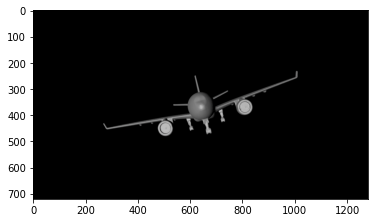

In [ ]:
n = 0
img_name = data_csv.iloc[n, 0]
marks = data_csv.iloc[n, 1:]
marks = np.asarray(marks)
# marks = marks.astype('float').reshape(-1, 2)


def show_marks(image, marks):
    """Show image with landmarks"""
    print(*marks)
    plt.imshow(image)
    
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_marks(io.imread(os.path.join(root_dir, img_name)),
               marks)
plt.show()

In [ ]:
class MarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.data.iloc[idx, 0])
        image = io.imread(img_name)
        marks = self.data.iloc[idx, 1:]
        marks = np.array(marks)
        marks = marks.astype('float')
        sample = {'image': image, 'marks': marks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
dataset = MarksDataset(csv_file='/content/gdrive/MyDrive/Hacks/data.csv',
                                    root_dir=root_dir)

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for marks because for images,
        # x and y axes are axis 1 and 0 respectively
        
        return {'image': img, 'marks': marks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'marks': marks}


class CenterCrop(object):
    """Crop center the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = h//2 - new_h//2
        left = w//2 - new_w//2

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'marks': marks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'marks': torch.from_numpy(marks)}

In [ ]:
transformed_dataset = MarksDataset(csv_file='/content/gdrive/MyDrive/Hacks/data.csv',
                                    root_dir=root_dir,
                                           transform=transforms.Compose([
                                               Rescale(300),
                                               CenterCrop(224),
                                               ToTensor()
                                           ]))

In [ ]:
batch_size = 10
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_marks_batch(sample_batched):
    """Show image with marks for a batch of samples."""
    images_batch, marks_batch = \
            sample_batched['image'], sample_batched['marks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 5

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, size=224):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for batch in train_loader:
        inputs = batch['image'].view(-1, 3, size, size)
        inputs = inputs.float()
        marks = batch['marks'].view(-1, 3)
        marks = marks.float()
        inputs = inputs.to(DEVICE)
        marks = marks.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, marks)
        loss.backward()
        optimizer.step()
        preds = outputs
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(abs(preds.data - marks.data) < 10)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion, size=224):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for batch in val_loader:
        inputs = batch['image'].view(-1, 3, size, size)
        inputs = inputs.float()
        marks = batch['marks'].view(-1, 3)
        marks = marks.float()
        inputs = inputs.to(DEVICE)
        marks = marks.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, marks)
            preds = outputs

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum((abs(preds.data - marks.data) < 10).min())
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def show_loss(history):
    loss, _, val_loss, _ = zip(*history)
    plt.figure(figsize=(12, 6))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None, lr=0.01):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 15, 0.1)
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            train_loss = train_loss ** 0.5
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            val_loss = val_loss ** 0.5
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        
            
    return history

In [ ]:
def predict(model, test_loader, size=224):
    with torch.no_grad():
        logits = []
    
        for batch in test_loader:
            inputs = batch['image'].view(-1, 3, size, size)
            inputs = inputs.float()
            inputs = inputs.to(DEVICE)

            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = logits
    return probs

In [ ]:
model_resnet = models.resnet34(pretrained=True)
model_resnet.fc = nn.Sequential(
                                nn.Linear(in_features=model_resnet.fc.in_features, out_features=64),
                                nn.ReLU(),
                                nn.Linear(64, 3))
model_resnet = model_resnet.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

In [19]:
history = train(transformed_dataset, transformed_dataset, model=model_resnet, epochs=60, 
                batch_size=10, lr=0.1
               )

epoch:   0%|          | 0/60 [00:00<?, ?it/s]

loss 73.93080673397465


epoch:   2%|▏         | 1/60 [04:06<4:02:45, 246.87s/it]


Epoch 001 train_loss: 73.9308     val_loss 60.3067 train_acc 0.7220 val_acc 0.0000
loss 59.789282654011664


epoch:   3%|▎         | 2/60 [06:19<2:53:49, 179.82s/it]


Epoch 002 train_loss: 59.7893     val_loss 58.0972 train_acc 0.8626 val_acc 0.0000
loss 50.33487081689992


epoch:   5%|▌         | 3/60 [08:32<2:30:24, 158.32s/it]


Epoch 003 train_loss: 50.3349     val_loss 45.8187 train_acc 0.9617 val_acc 0.0000
loss 48.54802230988203


epoch:   7%|▋         | 4/60 [10:45<2:18:31, 148.42s/it]


Epoch 004 train_loss: 48.5480     val_loss 48.6394 train_acc 1.0224 val_acc 0.0000
loss 42.965908545408425


epoch:   8%|▊         | 5/60 [12:58<2:10:53, 142.80s/it]


Epoch 005 train_loss: 42.9659     val_loss 39.2091 train_acc 0.9712 val_acc 0.0000
loss 39.75129173590336


epoch:  10%|█         | 6/60 [15:11<2:05:22, 139.31s/it]


Epoch 006 train_loss: 39.7513     val_loss 37.9387 train_acc 1.0703 val_acc 0.0000
loss 35.38562231901826


epoch:  12%|█▏        | 7/60 [17:23<2:01:07, 137.13s/it]


Epoch 007 train_loss: 35.3856     val_loss 30.0560 train_acc 1.0927 val_acc 0.0000
loss 31.498747276407116


epoch:  13%|█▎        | 8/60 [19:35<1:57:18, 135.36s/it]


Epoch 008 train_loss: 31.4987     val_loss 27.0495 train_acc 1.1597 val_acc 0.0000
loss 30.619169455356847


epoch:  15%|█▌        | 9/60 [21:46<1:53:59, 134.12s/it]


Epoch 009 train_loss: 30.6192     val_loss 26.9829 train_acc 1.1885 val_acc 0.0000
loss 30.229936597495712


epoch:  17%|█▋        | 10/60 [23:58<1:51:10, 133.40s/it]


Epoch 010 train_loss: 30.2299     val_loss 26.9048 train_acc 1.1597 val_acc 0.0000
loss 28.516242402721414


epoch:  18%|█▊        | 11/60 [26:10<1:48:34, 132.94s/it]


Epoch 011 train_loss: 28.5162     val_loss 26.6728 train_acc 1.1629 val_acc 0.0000
loss 33.60172739212635


epoch:  20%|██        | 12/60 [28:22<1:46:03, 132.57s/it]


Epoch 012 train_loss: 33.6017     val_loss 28.1610 train_acc 1.0607 val_acc 0.0000
loss 28.715949043443914


epoch:  22%|██▏       | 13/60 [30:33<1:43:37, 132.29s/it]


Epoch 013 train_loss: 28.7159     val_loss 27.2689 train_acc 1.1022 val_acc 0.0000
loss 25.143071170861592


epoch:  23%|██▎       | 14/60 [32:45<1:41:14, 132.06s/it]


Epoch 014 train_loss: 25.1431     val_loss 23.0325 train_acc 1.1534 val_acc 0.0000
loss 24.220891428486873


epoch:  25%|██▌       | 15/60 [34:56<1:38:54, 131.87s/it]


Epoch 015 train_loss: 24.2209     val_loss 23.2092 train_acc 1.2013 val_acc 0.0000
loss 21.685726333306434


epoch:  27%|██▋       | 16/60 [37:08<1:36:37, 131.75s/it]


Epoch 016 train_loss: 21.6857     val_loss 20.4297 train_acc 1.3003 val_acc 0.0000
loss 20.628916756761583


epoch:  28%|██▊       | 17/60 [39:19<1:34:21, 131.67s/it]


Epoch 017 train_loss: 20.6289     val_loss 19.8690 train_acc 1.3163 val_acc 0.0000
loss 19.98771901506806


epoch:  30%|███       | 18/60 [41:30<1:32:04, 131.52s/it]


Epoch 018 train_loss: 19.9877     val_loss 19.8111 train_acc 1.3387 val_acc 0.0000
loss 19.85828114564312


epoch:  32%|███▏      | 19/60 [43:42<1:29:50, 131.48s/it]


Epoch 019 train_loss: 19.8583     val_loss 19.7909 train_acc 1.3482 val_acc 0.0000
loss 19.88524173448031


epoch:  33%|███▎      | 20/60 [45:53<1:27:37, 131.43s/it]


Epoch 020 train_loss: 19.8852     val_loss 19.7767 train_acc 1.3674 val_acc 0.0000
loss 19.68636141178033


epoch:  35%|███▌      | 21/60 [48:05<1:25:26, 131.46s/it]


Epoch 021 train_loss: 19.6864     val_loss 19.2197 train_acc 1.3642 val_acc 0.0000
loss 19.416709962029664


epoch:  37%|███▋      | 22/60 [50:16<1:23:13, 131.42s/it]


Epoch 022 train_loss: 19.4167     val_loss 19.9288 train_acc 1.3738 val_acc 0.0000
loss 19.51310743331482


epoch:  38%|███▊      | 23/60 [52:28<1:21:08, 131.59s/it]


Epoch 023 train_loss: 19.5131     val_loss 18.9828 train_acc 1.3291 val_acc 0.0000
loss 19.142573387846177


epoch:  40%|████      | 24/60 [54:39<1:18:53, 131.48s/it]


Epoch 024 train_loss: 19.1426     val_loss 18.8860 train_acc 1.3834 val_acc 0.0000
loss 19.010113092879365


epoch:  42%|████▏     | 25/60 [56:50<1:16:36, 131.34s/it]


Epoch 025 train_loss: 19.0101     val_loss 19.3008 train_acc 1.3898 val_acc 0.0000
loss 19.23235001582529


epoch:  43%|████▎     | 26/60 [59:01<1:14:25, 131.34s/it]


Epoch 026 train_loss: 19.2324     val_loss 18.6867 train_acc 1.3706 val_acc 0.0000
loss 18.99850074365496


epoch:  45%|████▌     | 27/60 [1:01:13<1:12:13, 131.31s/it]


Epoch 027 train_loss: 18.9985     val_loss 18.6140 train_acc 1.3738 val_acc 0.0000
loss 18.97489704654805


epoch:  47%|████▋     | 28/60 [1:03:24<1:10:00, 131.26s/it]


Epoch 028 train_loss: 18.9749     val_loss 18.4815 train_acc 1.4121 val_acc 0.0000
loss 18.98572164269832


epoch:  48%|████▊     | 29/60 [1:05:35<1:07:47, 131.22s/it]


Epoch 029 train_loss: 18.9857     val_loss 18.5333 train_acc 1.4026 val_acc 0.0000
loss 18.60099598126272


epoch:  50%|█████     | 30/60 [1:07:46<1:05:35, 131.18s/it]


Epoch 030 train_loss: 18.6010     val_loss 18.2782 train_acc 1.3962 val_acc 0.0000
loss 18.287829086332618


epoch:  52%|█████▏    | 31/60 [1:09:57<1:03:24, 131.20s/it]


Epoch 031 train_loss: 18.2878     val_loss 18.2488 train_acc 1.4473 val_acc 0.0000
loss 18.26524694666814


epoch:  53%|█████▎    | 32/60 [1:12:08<1:01:12, 131.17s/it]


Epoch 032 train_loss: 18.2652     val_loss 18.2250 train_acc 1.4505 val_acc 0.0000
loss 18.29231219339793


epoch:  55%|█████▌    | 33/60 [1:14:19<59:00, 131.11s/it]


Epoch 033 train_loss: 18.2923     val_loss 18.2233 train_acc 1.4505 val_acc 0.0000
loss 18.227463677251045


epoch:  57%|█████▋    | 34/60 [1:16:30<56:47, 131.06s/it]


Epoch 034 train_loss: 18.2275     val_loss 18.2000 train_acc 1.4441 val_acc 0.0000
loss 18.24094164027167


epoch:  58%|█████▊    | 35/60 [1:18:41<54:34, 130.98s/it]


Epoch 035 train_loss: 18.2409     val_loss 18.1861 train_acc 1.4313 val_acc 0.0000
loss 18.214419184428298


epoch:  60%|██████    | 36/60 [1:20:52<52:24, 131.02s/it]


Epoch 036 train_loss: 18.2144     val_loss 18.1753 train_acc 1.4441 val_acc 0.0000
loss 18.19732240155565


epoch:  62%|██████▏   | 37/60 [1:23:03<50:12, 130.98s/it]


Epoch 037 train_loss: 18.1973     val_loss 18.1654 train_acc 1.4377 val_acc 0.0000
loss 18.188944664466725


epoch:  63%|██████▎   | 38/60 [1:25:14<47:59, 130.88s/it]


Epoch 038 train_loss: 18.1889     val_loss 18.1532 train_acc 1.4505 val_acc 0.0000
loss 18.184574633947637


epoch:  65%|██████▌   | 39/60 [1:27:25<45:48, 130.87s/it]


Epoch 039 train_loss: 18.1846     val_loss 18.1391 train_acc 1.4441 val_acc 0.0000
loss 18.165563297376334


epoch:  67%|██████▋   | 40/60 [1:29:36<43:42, 131.14s/it]


Epoch 040 train_loss: 18.1656     val_loss 18.1322 train_acc 1.4409 val_acc 0.0000
loss 18.197945380569838


epoch:  68%|██████▊   | 41/60 [1:31:48<41:31, 131.16s/it]


Epoch 041 train_loss: 18.1979     val_loss 18.1272 train_acc 1.4313 val_acc 0.0000
loss 18.14850587948661


epoch:  70%|███████   | 42/60 [1:33:59<39:21, 131.20s/it]


Epoch 042 train_loss: 18.1485     val_loss 18.1085 train_acc 1.4505 val_acc 0.0000
loss 18.145121994584596


epoch:  72%|███████▏  | 43/60 [1:36:10<37:12, 131.32s/it]


Epoch 043 train_loss: 18.1451     val_loss 18.0986 train_acc 1.4281 val_acc 0.0000
loss 18.12333786056698


epoch:  73%|███████▎  | 44/60 [1:38:22<35:00, 131.27s/it]


Epoch 044 train_loss: 18.1233     val_loss 18.0840 train_acc 1.4569 val_acc 0.0000
loss 18.102426013319004


epoch:  75%|███████▌  | 45/60 [1:40:33<32:49, 131.31s/it]


Epoch 045 train_loss: 18.1024     val_loss 18.0702 train_acc 1.4473 val_acc 0.0000
loss 18.07226016759841


epoch:  77%|███████▋  | 46/60 [1:42:44<30:37, 131.22s/it]


Epoch 046 train_loss: 18.0723     val_loss 18.0670 train_acc 1.4505 val_acc 0.0000
loss 18.069528212386192


epoch:  78%|███████▊  | 47/60 [1:44:56<28:26, 131.30s/it]


Epoch 047 train_loss: 18.0695     val_loss 18.0643 train_acc 1.4537 val_acc 0.0000
loss 18.06708168267513


epoch:  80%|████████  | 48/60 [1:47:07<26:15, 131.32s/it]


Epoch 048 train_loss: 18.0671     val_loss 18.0629 train_acc 1.4537 val_acc 0.0000
loss 18.06612098794737


epoch:  82%|████████▏ | 49/60 [1:49:18<24:04, 131.35s/it]


Epoch 049 train_loss: 18.0661     val_loss 18.0613 train_acc 1.4537 val_acc 0.0000
loss 18.065063336508793


epoch:  83%|████████▎ | 50/60 [1:51:30<21:54, 131.43s/it]


Epoch 050 train_loss: 18.0651     val_loss 18.0600 train_acc 1.4537 val_acc 0.0000
loss 18.06242637535351


epoch:  85%|████████▌ | 51/60 [1:53:41<19:42, 131.39s/it]


Epoch 051 train_loss: 18.0624     val_loss 18.0585 train_acc 1.4569 val_acc 0.0000
loss 18.062251496131886


epoch:  87%|████████▋ | 52/60 [1:55:53<17:31, 131.43s/it]


Epoch 052 train_loss: 18.0623     val_loss 18.0572 train_acc 1.4601 val_acc 0.0000
loss 18.05960848603491


epoch:  88%|████████▊ | 53/60 [1:58:04<15:20, 131.43s/it]


Epoch 053 train_loss: 18.0596     val_loss 18.0557 train_acc 1.4601 val_acc 0.0000
loss 18.059026740907825


epoch:  90%|█████████ | 54/60 [2:00:16<13:08, 131.45s/it]


Epoch 054 train_loss: 18.0590     val_loss 18.0543 train_acc 1.4569 val_acc 0.0000
loss 18.05895583061954


epoch:  92%|█████████▏| 55/60 [2:02:27<10:57, 131.50s/it]


Epoch 055 train_loss: 18.0590     val_loss 18.0527 train_acc 1.4601 val_acc 0.0000
loss 18.055571462622602


epoch:  93%|█████████▎| 56/60 [2:04:39<08:45, 131.47s/it]


Epoch 056 train_loss: 18.0556     val_loss 18.0511 train_acc 1.4569 val_acc 0.0000
loss 18.053892519043362


epoch:  95%|█████████▌| 57/60 [2:06:50<06:34, 131.53s/it]


Epoch 057 train_loss: 18.0539     val_loss 18.0496 train_acc 1.4537 val_acc 0.0000
loss 18.054542955702164


epoch:  97%|█████████▋| 58/60 [2:09:01<04:22, 131.42s/it]


Epoch 058 train_loss: 18.0545     val_loss 18.0484 train_acc 1.4537 val_acc 0.0000
loss 18.05340329495241


epoch:  98%|█████████▊| 59/60 [2:11:13<02:11, 131.38s/it]


Epoch 059 train_loss: 18.0534     val_loss 18.0465 train_acc 1.4505 val_acc 0.0000
loss 18.050623539355254


epoch: 100%|██████████| 60/60 [2:13:24<00:00, 133.41s/it]


Epoch 060 train_loss: 18.0506     val_loss 18.0454 train_acc 1.4537 val_acc 0.0000


In [21]:
torch.save(model_resnet.state_dict(), '/content/gdrive/MyDrive/Hacks/weights_ver3.pth')

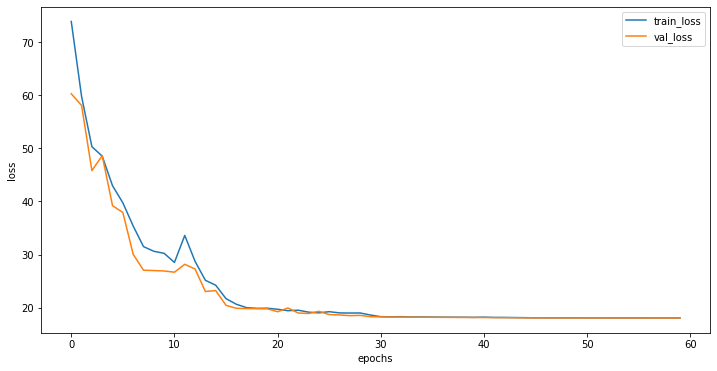

In [20]:
all_history = history
show_loss(all_history)

In [22]:
test_dataset = MarksDataset(csv_file='/content/gdrive/MyDrive/Hacks/test_data.csv',
                                    root_dir=test_root_dir,
                                           transform=transforms.Compose([
                                               Rescale(300),
                                               CenterCrop(224),
                                               ToTensor()
                                           ]))

In [23]:
batch_size = 10
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

In [24]:
test_data_csv

,name,k,t,r
0,0_0_0.tif,0.0,0.0,0.0
1,30_0_0.tif,30.0,0.0,0.0
2,-30_0_0.tif,-30.0,0.0,0.0
3,0_20_0.tif,0.0,20.0,0.0
4,0_-20_0.tif,0.0,-20.0,0.0
5,0_0_40.tif,0.0,0.0,40.0
6,0_0_320.tif,0.0,0.0,320.0
7,-45_10_340.tif,-45.0,10.0,340.0
8,-45_-20_340.tif,-45.0,-20.0,340.0
9,1.5_-9_315.png,1.5,-9.0,315.0


In [ ]:
np.round(predict(model_resnet, test_dataloader)[0], 0)

tensor([[ -4.,   0., 318.],
        [ -1.,   0.,   8.],
        [-40.,  12., 360.],
        [ -8., -11.,   9.],
        [ -1.,   0.,   0.],
        [-38., -20., 344.],
        [ -8.,  -5.,   3.],
        [  0.,  18.,  11.],
        [  3.,  -0.,  51.],
        [ -5., -12., 308.]])